<a href="https://colab.research.google.com/github/KirillR911/SkyGan/blob/master/NStTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import os 

image_dir = '/content/drive/My Drive/NAASt/Imgs/'
model_dir = '/content/drive/My Drive/NAASt/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict

import matplotlib.pyplot as plt

In [0]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #CONV LAYERS
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        #HANDLE POOLING OPTIONS
        #MAX POOLING
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
            self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #AVERAGE POOLING
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool3 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool4 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            self.pool5 = nn.AvgPool2d(kernel_size = 2, stride = 2)
            
        #FORWARD PROP
    def forward(self, x, out_keys):
        out = {}
        
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        
        
        #RETURN DESIRED ACTIVATIONs
        return [out[key] for key in out_keys]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, w, h = input.size()
        F = input.view(b, c, h * w)
        #COMPUTES GRAM MATRIX BY MULTIPLYING INPUT BY TRANPOSE OF ITSELF
        G = torch.bmm(F, F.transpose(1, 2))
        G.div_(h*w)
        return G

In [0]:
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [0]:
img_size = 1000

#PRE-PROCESSING
prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]), #CONVERT TO BGR FOR VGG NET
                           transforms.Normalize(mean = [0.40760392, 0.45795686, 0.48501961], std = [1, 1, 1]), #SUBTRACT IMAGENET MEAN
                           transforms.Lambda(lambda x: x.mul_(255)), #VGG WAS TRAINED WITH PIXEL VALUES 0-255
])

#POST PROCESSING A
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                            transforms.Normalize(mean = [-0.40760392, -0.45795686, -0.48501961], std = [1, 1, 1]),
                            transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),    
        ])
    
#POST PROCESSING B
postpb = transforms.Compose([transforms.ToPILImage()])

#POST PROCESSING FUNCTION INCORPORATES A AND B, AND CLIPS PIXEL VALUES WHICH ARE OUT OF RANGE
def postp(tensor):
    t = postpa(tensor)
    t[t>1] = 1
    t[t<0] = 0
    img = postpb(t)
    return img

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:209: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [0]:
vgg = VGG()

vgg.load_state_dict(torch.load(model_dir + 'vgg_conv_weights.pth'))            
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [0]:
img_dirs = [image_dir, image_dir]

In [0]:
img_names = ['sky_style.jpg', 'pasha_style.jpg']
imgs = [Image.open(img_dirs[i] + name) for i, name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]

In [0]:
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0)).cuda() for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_img, content_img = imgs_torch
for img in imgs_torch:
  print("Image size: ", img.size())


Image size:  torch.Size([1, 3, 1000, 1000])
Image size:  torch.Size([1, 3, 1000, 1658])


In [0]:
opt_img = Variable(content_img.clone(), requires_grad = True)
print(content_img.size())
print(opt_img.size())

torch.Size([1, 3, 1000, 1658])
torch.Size([1, 3, 1000, 1658])


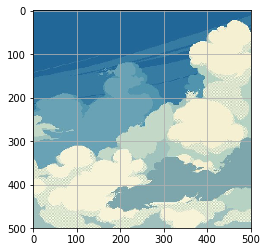

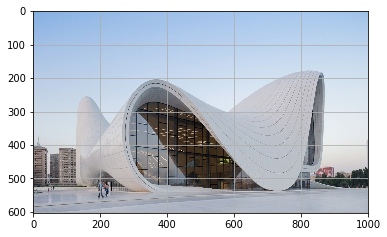

In [0]:
for img in imgs:
    plt.grid(None)
    plt.imshow(img)
    plt.show()

In [0]:
style_layers = ['r11', 'r12', 'r31', 'r41', 'r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

In [0]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns] 

In [0]:
style_weights = [1e3/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e0]
weights = style_weights + content_weights

In [0]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_img, style_layers)]
content_targets = [A.detach() for A in vgg(content_img, content_layers)]
targets = style_targets + content_targets

In [0]:
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img])
print(opt_img.size())
print(content_img.size())
n_iter = [0]


torch.Size([1, 3, 1000, 1658])
torch.Size([1, 3, 1000, 1658])


In [0]:
while n_iter[0] <= max_iter:
  
    def closure():
        optimizer.zero_grad()
        
        #FORWARD
        out = vgg(opt_img, loss_layers)
        
        #LOSS
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        
        #BACKWARDS
        loss.backward()
        
        #TRACK PROGRESS
        n_iter[0] += 1
        if n_iter[0] % show_iter == (show_iter - 1):
            print('Iteration: %d,\tLoss: %f' % (n_iter[0] + 1, loss.item()))
            
        return loss
    
    optimizer.step(closure)

Iteration: 50,	Loss: 120401.500000
Iteration: 100,	Loss: 118710.195312
Iteration: 150,	Loss: 117011.640625
Iteration: 200,	Loss: 115436.945312
Iteration: 250,	Loss: 114037.414062
Iteration: 300,	Loss: 112829.312500
Iteration: 350,	Loss: 111748.281250
Iteration: 400,	Loss: 110888.101562
Iteration: 450,	Loss: 110138.835938
Iteration: 500,	Loss: 109491.804688


1658.0
1658.0
1658.0


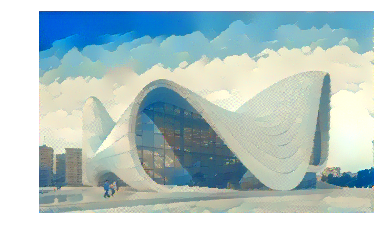

In [0]:
print(float(opt_img.size(3)))
print(float(content_img.size(3)))
out_img = postp(opt_img.data[0].cpu().squeeze())
print(float(prep(out_img).size(2)))
plt.grid(None)
plt.axis('off')

plt.imshow(out_img)
#plt.gcf().set_size_inches(10, 10)
plt.savefig('out.png', bbox_inches='tight')

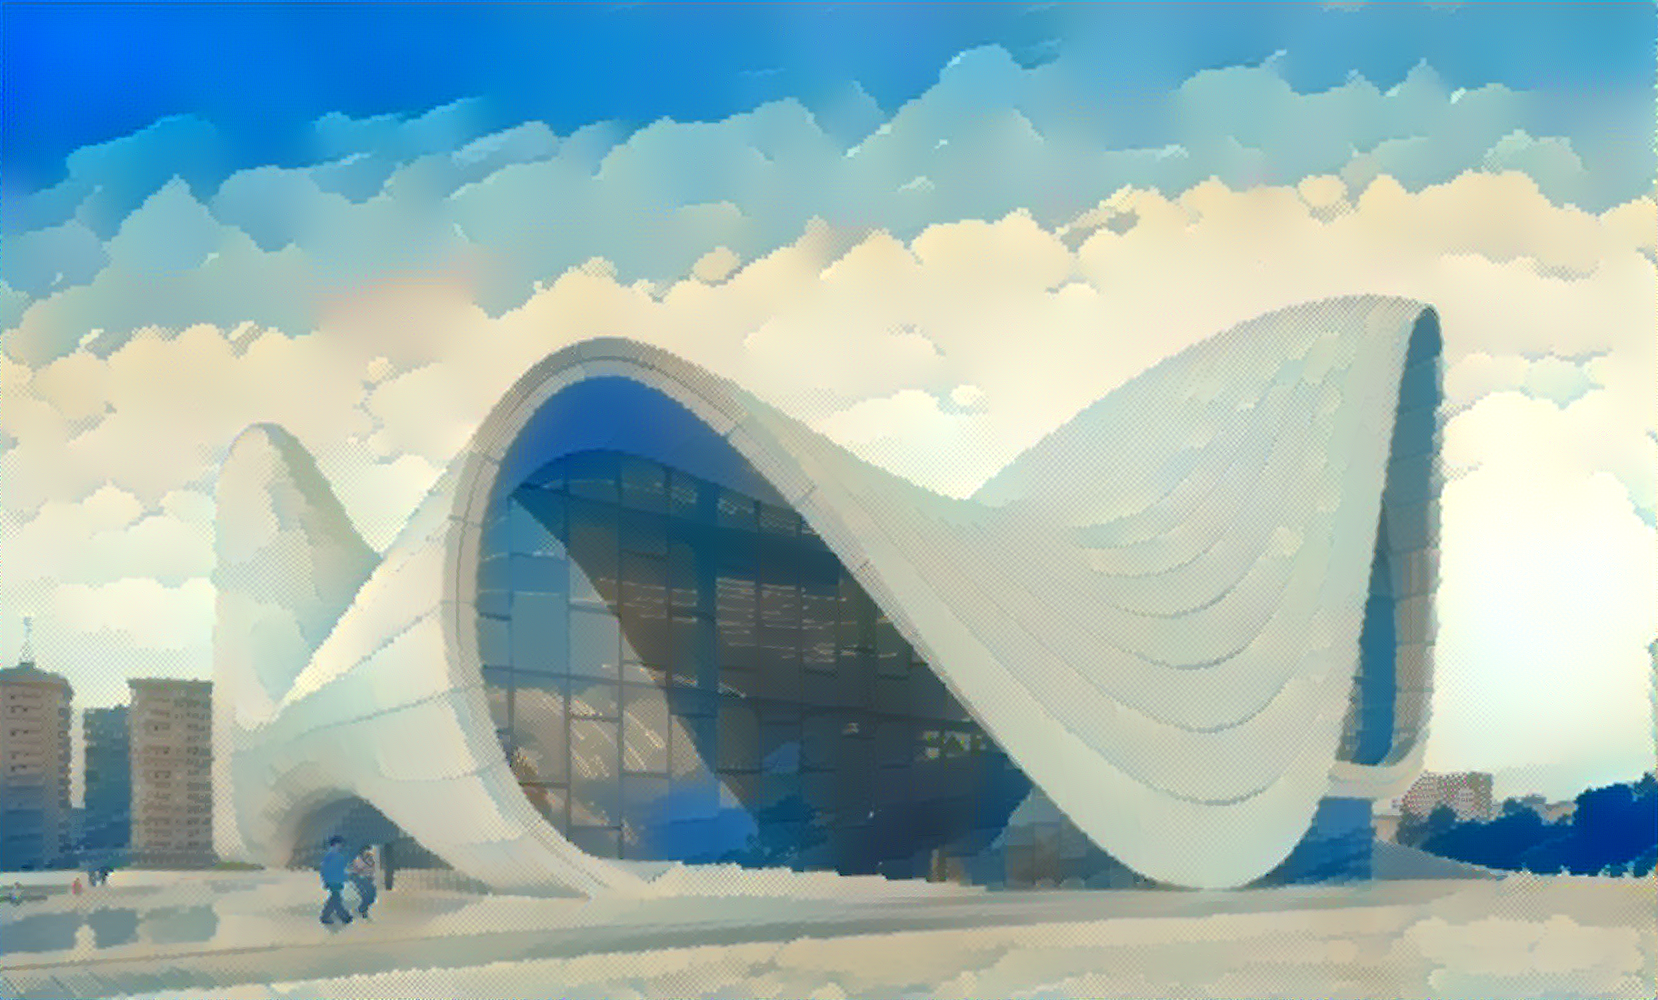

In [0]:
out_img

In [0]:
out_img.save('out.png')